In [28]:
# Core libraries
import pandas as pd
import numpy as np
import re

# NLP libraries
import nltk
from nltk.corpus import stopwords


# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [10]:
import os
print("Current working directory:", os.getcwd())
print("Files in folder:", os.listdir())


Current working directory: C:\Users\Suraj\Desktop\Spam Detection
Files in folder: ['.ipynb_checkpoints', 'readme', 'SMSSpamCollection', 'spam_model.pkl', 'tfidf_vectorizer.pkl', 'Untitled.ipynb', 'Untitled1.ipynb']


In [11]:
import pandas as pd

data = pd.read_csv(
    "SMSSpamCollection",  # exact filename
    sep="\t",             # tab-separated file
    header=None,
    names=["label", "message"],
    encoding="latin-1",
    engine="python",
    on_bad_lines="skip"
)

print("Total rows:", data.shape[0])
print(data.head())


Total rows: 5562
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [12]:
# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.split()
    text = [word for word in text if word not in stopwords.words('english')]
    return ' '.join(text)

# Apply cleaning
data['clean_message'] = data['message'].apply(clean_text)

data.head()


,label,message,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though


In [30]:
# Checking missing values
data.isnull().sum()


label            0
message          0
clean_message    0
dtype: int64

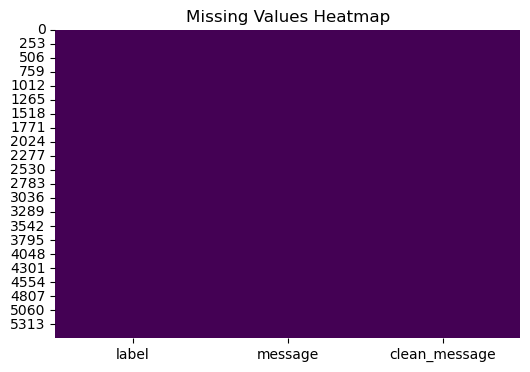

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of missing values
plt.figure(figsize=(6,4))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()


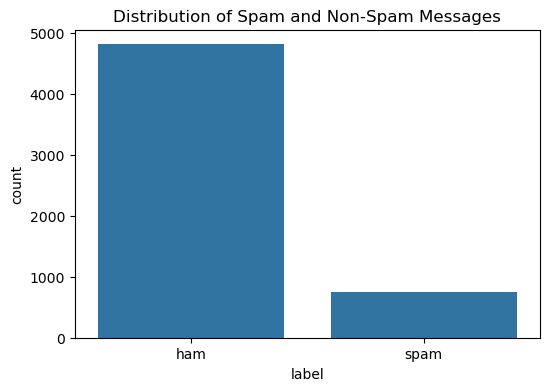

In [32]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data)
plt.title("Distribution of Spam and Non-Spam Messages")
plt.show()


In [59]:
message_stats = data.groupby('label')['message_length'].agg(['mean','median','std'])
print(message_stats)


             mean  median        std
label                               
ham     71.400000    52.0  58.310858
spam   139.119143   149.0  28.998900


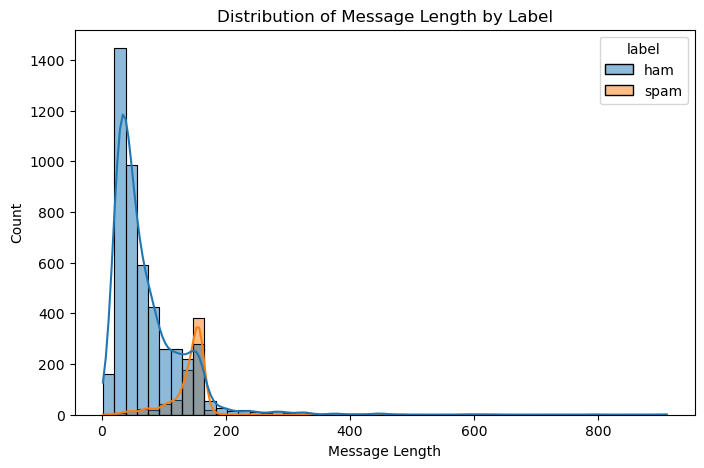

In [33]:
# Add message length column
data['message_length'] = data['message'].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(data=data, x='message_length', hue='label', bins=50, kde=True)
plt.title("Distribution of Message Length by Label")
plt.xlabel("Message Length")
plt.ylabel("Count")
plt.show()


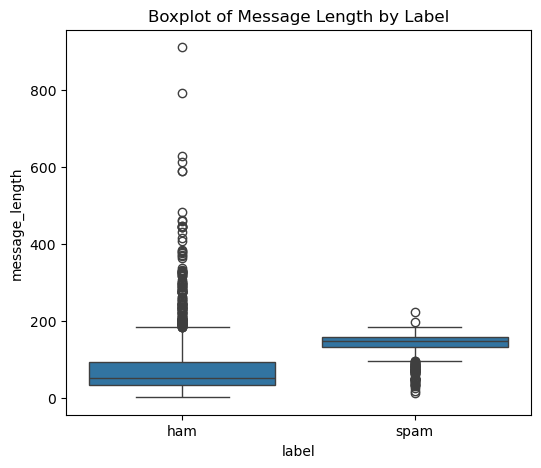

In [57]:
plt.figure(figsize=(6,5))
sns.boxplot(x='label', y='message_length', data=data)
plt.title("Boxplot of Message Length by Label")
plt.show()




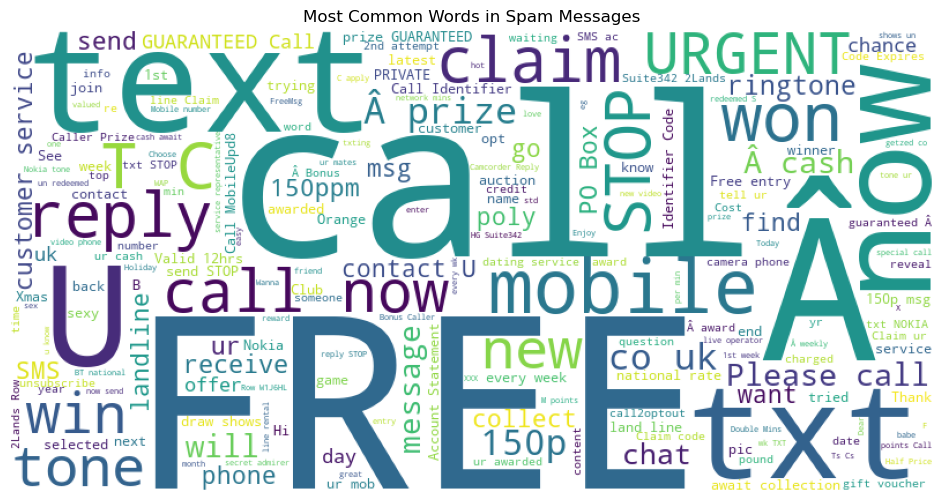

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

spam_words = ' '.join(data[data['label']=='spam']['message'])

wc = WordCloud(width=800, height=400, background_color='white').generate(spam_words)

plt.figure(figsize=(12,6))
plt.imshow(wc.to_image())   # <- Use to_image() instead of relying on __array__()
plt.axis('off')
plt.title("Most Common Words in Spam Messages")
plt.show()


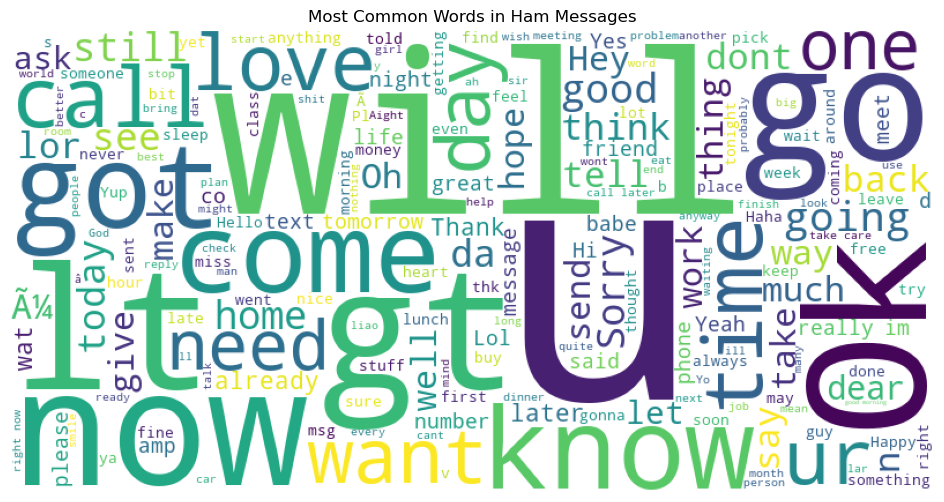

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all Ham messages
ham_words = ' '.join(data[data['label']=='ham']['message'])

# Generate WordCloud
ham_wc = WordCloud(width=800, height=400, background_color='white').generate(ham_words)

# Plot using to_image() to avoid TypeError
plt.figure(figsize=(12,6))
plt.imshow(ham_wc.to_image())  # <- Use to_image() here
plt.axis('off')
plt.title("Most Common Words in Ham Messages")
plt.show()


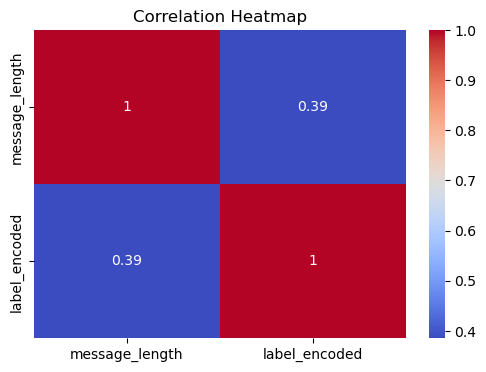

In [36]:
# Encode label for correlation
data['label_encoded'] = data['label'].map({'ham':0, 'spam':1})

plt.figure(figsize=(6,4))
sns.heatmap(data[['message_length','label_encoded']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [79]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['clean_message'])

# Target variable
y = data['label']

X.shape


(5562, 3000)

In [14]:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print("Training data size:", X_train.shape[0])
    print("Testing data size:", X_test.shape[0])


Training data size: 4449
Testing data size: 1113


In [66]:
nb = MultinomialNB()
nb.fit(X_train, y_train)


MultinomialNB()

In [67]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [68]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)


KNeighborsClassifier()

In [69]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [71]:
models = {
    "Naive Bayes": nb,
    "Logistic Regression": lr,
    "KNN": knn,
    "Random Forest": rf
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))



Naive Bayes
Accuracy: 0.9856244384546271
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       967
        spam       1.00      0.89      0.94       146

    accuracy                           0.99      1113
   macro avg       0.99      0.95      0.97      1113
weighted avg       0.99      0.99      0.99      1113


Logistic Regression
Accuracy: 0.9667565139263252
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       967
        spam       0.97      0.77      0.86       146

    accuracy                           0.97      1113
   macro avg       0.97      0.88      0.92      1113
weighted avg       0.97      0.97      0.97      1113


KNN
Accuracy: 0.9209344115004492
              precision    recall  f1-score   support

         ham       0.92      1.00      0.96       967
        spam       1.00      0.40      0.57       146

    accuracy                           0.92      1113
  

In [17]:
confusion_matrix(y_test, rf.predict(X_test))


array([[966,   1],
       [ 22, 124]], dtype=int64)

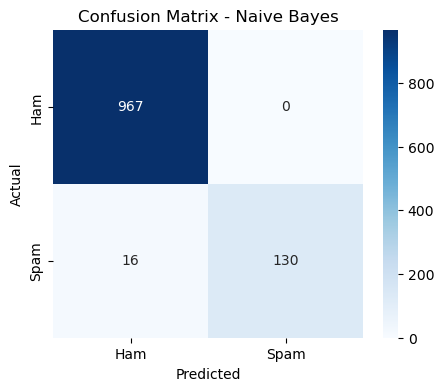

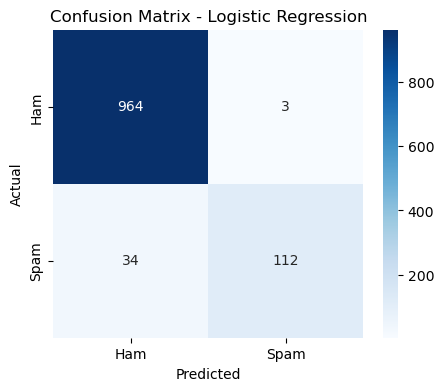

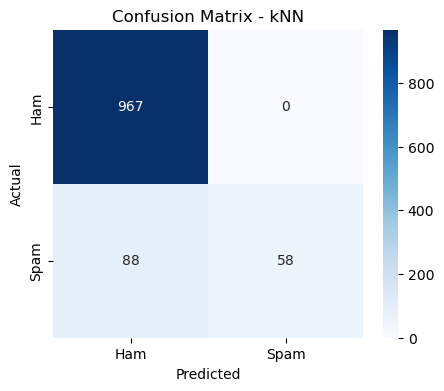

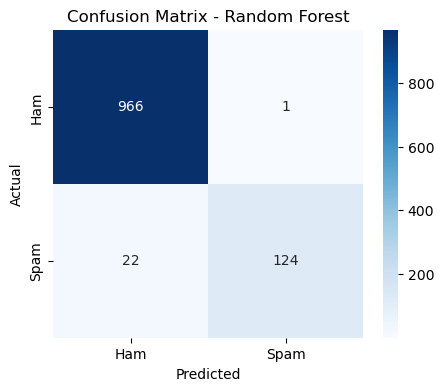

In [51]:
from sklearn.metrics import confusion_matrix

models = {"Naive Bayes": nb, "Logistic Regression": lr, "kNN": knn, "Random Forest": rf}

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


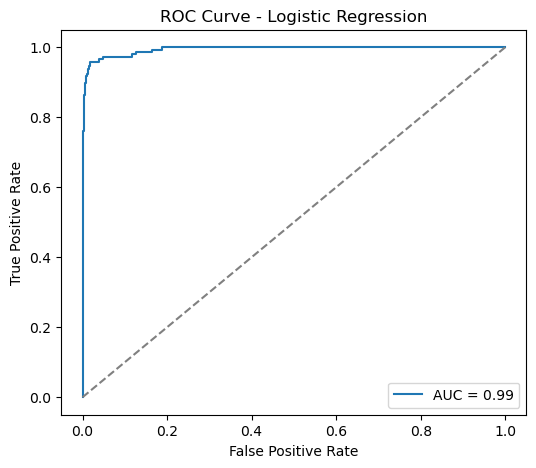

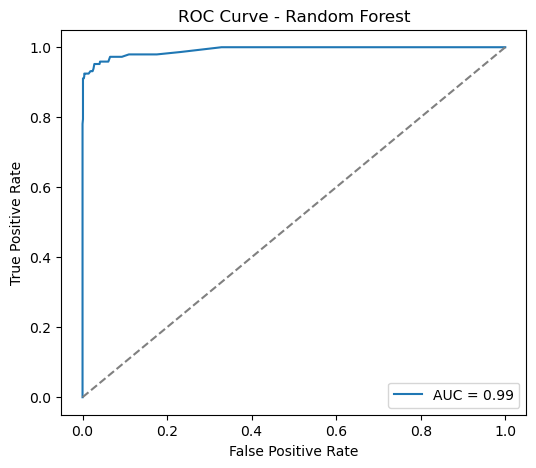

In [52]:
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import label_binarize

# Convert labels to binary
y_test_bin = label_binarize(y_test, classes=['ham','spam']).ravel()

for name, model in [("Logistic Regression", lr), ("Random Forest", rf)]:
    y_pred_prob = model.predict_proba(X_test)[:,1]  # Probability of spam
    fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc="lower right")
    plt.show()


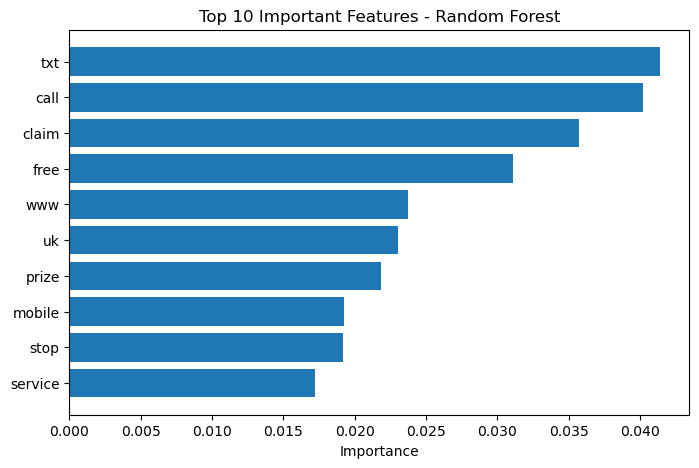

In [53]:
# Random Forest feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

top_features = [tfidf.get_feature_names_out()[i] for i in indices]

plt.figure(figsize=(8,5))
plt.barh(top_features, importances[indices])
plt.title("Top 10 Important Features - Random Forest")
plt.xlabel("Importance")
plt.show()


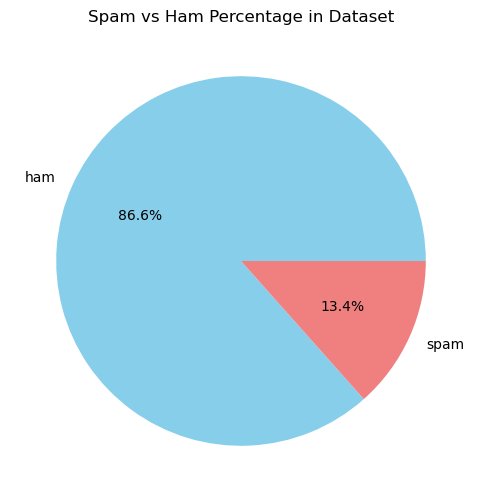

In [54]:
plt.figure(figsize=(6,6))
data['label'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue','lightcoral'])
plt.title("Spam vs Ham Percentage in Dataset")
plt.ylabel("")
plt.show()


In [23]:
def check_sms_spam():
    user_message = input("Enter an SMS message: ")
    
    cleaned_message = clean_text(user_message)
    message_vector = tfidf.transform([cleaned_message])
    
    prediction = lr.predict(message_vector)
    
    if prediction[0] == "spam":
        print("🚨 Result: Spam Message")
    else:
        print("✅ Result: Not Spam Message")


In [84]:
check_sms_spam()


Enter an SMS message:  Congratulations! You won a free prize. Call now!


🚨 Result: Spam Message
